In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [3]:
def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [387]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.lin = nn.Linear(64*6*6, latent_size)
    
    def forward(self, x):
#         print(x.shape)
        x = torch.relu(self.conv1(x))
#         print(x.shape)
        x = torch.relu(self.conv2(x))
#         print(x.shape)
        x = torch.reshape(x, (50, -1))
#         print(x.shape)
        x = torch.sigmoid(self.lin(x))
#         print(x.shape)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.lin = nn.Linear(latent_size, 64*6*6)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, output_padding=1)
    
    def forward(self, x):
#         print(x.shape)
        x = torch.tanh(self.lin(x))
#         print(x.shape)
        x = torch.reshape(x, (50, 64, 6, 6))
#         print(x.shape)
        x = torch.relu(self.deconv1(x))
#         print(x.shape)
        x = torch.tanh(self.deconv2(x))
#         print(x.shape)
        return x

In [388]:
class Net(nn.Module):
    def __init__(self, latent_size=16, loss_fn=F.mse_loss, lr=1e-4, l2=0., simple_rho=False):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.simple_rho = simple_rho
        
    def forward(self, x):
#         x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        if (self.simple_rho):
            dkl = - rho * torch.log(self.data_rho) - (1-rho) * torch.log(1-self.data_rho)
        else:
            dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
            
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
#         target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [400]:
models = {'net': Net(512)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [401]:
def train(epoch, models, log=None, noisy=False, zero_half=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        
        train_data = torch.Tensor(np.copy(data))
        if noisy:
            train_data += torch.randn_like(data)           
        if zero_half:
            train_data[:, :, :, :14] = 0                
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(train_data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [402]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [403]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses net: 0.857744
Train Epoch: 1 [10000/50000 (20%)]	Losses net: 0.354131
Train Epoch: 1 [20000/50000 (40%)]	Losses net: 0.234211
Train Epoch: 1 [30000/50000 (60%)]	Losses net: 0.170046
Train Epoch: 1 [40000/50000 (80%)]	Losses net: 0.140114
Train Epoch: 1 [50000/50000 (100%)]	Losses net: 0.123163
Test set:
net: loss: 0.1185	rho_loss: 0.0001

Train Epoch: 2 [0/50000 (0%)]	Losses net: 0.110926
Train Epoch: 2 [10000/50000 (20%)]	Losses net: 0.105279
Train Epoch: 2 [20000/50000 (40%)]	Losses net: 0.096630
Train Epoch: 2 [30000/50000 (60%)]	Losses net: 0.094645
Train Epoch: 2 [40000/50000 (80%)]	Losses net: 0.083998
Train Epoch: 2 [50000/50000 (100%)]	Losses net: 0.086650
Test set:
net: loss: 0.0806	rho_loss: 0.0001

Train Epoch: 3 [0/50000 (0%)]	Losses net: 0.082019
Train Epoch: 3 [10000/50000 (20%)]	Losses net: 0.079096
Train Epoch: 3 [20000/50000 (40%)]	Losses net: 0.072245
Train Epoch: 3 [30000/50000 (60%)]	Losses net: 0.069181
Train Epoch: 3 [40000/500

In [404]:
data, _ = next(iter(test_loader))
output = models['net'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети

исходные данные


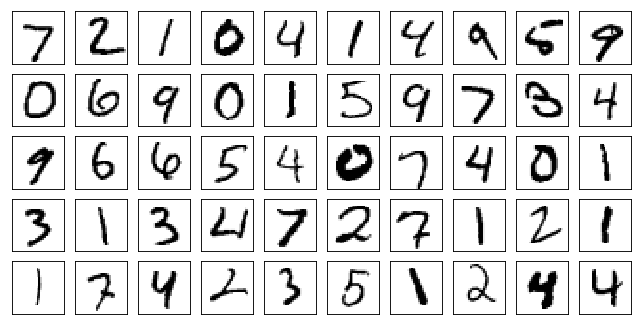

восстановленные данные


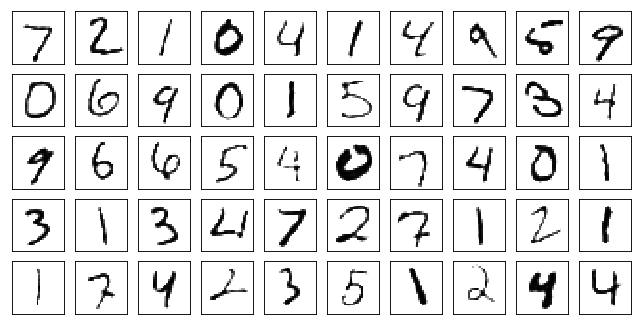

In [405]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))

In [406]:
models = {'net': Net(512)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [407]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, noisy=True)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses net: 1.051276
Train Epoch: 1 [10000/50000 (20%)]	Losses net: 0.348710
Train Epoch: 1 [20000/50000 (40%)]	Losses net: 0.280447
Train Epoch: 1 [30000/50000 (60%)]	Losses net: 0.223348
Train Epoch: 1 [40000/50000 (80%)]	Losses net: 0.193073
Train Epoch: 1 [50000/50000 (100%)]	Losses net: 0.171317
Test set:
net: loss: 0.1766	rho_loss: 0.0005

Train Epoch: 2 [0/50000 (0%)]	Losses net: 0.168590
Train Epoch: 2 [10000/50000 (20%)]	Losses net: 0.164653
Train Epoch: 2 [20000/50000 (40%)]	Losses net: 0.145230
Train Epoch: 2 [30000/50000 (60%)]	Losses net: 0.139244
Train Epoch: 2 [40000/50000 (80%)]	Losses net: 0.137654
Train Epoch: 2 [50000/50000 (100%)]	Losses net: 0.136597
Test set:
net: loss: 0.1262	rho_loss: 0.0003

Train Epoch: 3 [0/50000 (0%)]	Losses net: 0.126108
Train Epoch: 3 [10000/50000 (20%)]	Losses net: 0.128373
Train Epoch: 3 [20000/50000 (40%)]	Losses net: 0.129971
Train Epoch: 3 [30000/50000 (60%)]	Losses net: 0.123260
Train Epoch: 3 [40000/500

In [409]:
data, _ = next(iter(test_loader))
data += torch.randn_like(data)
output = models['net'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети

исходные данные


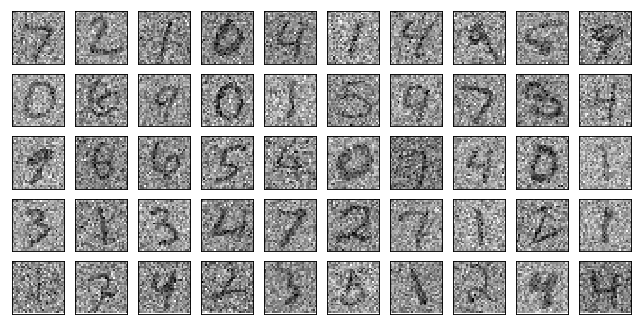

восстановленные данные


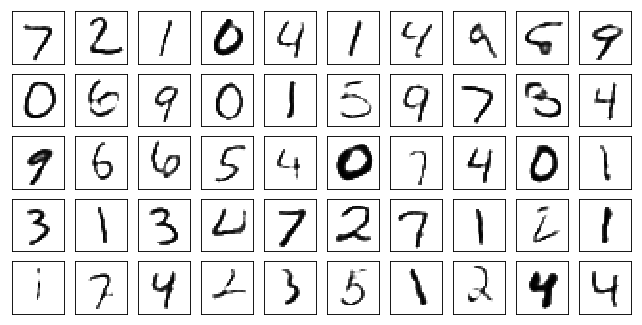

In [410]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))